In [1]:
# Import libraries

from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator

import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Create SparkSession

spark = SparkSession.builder.appName('Demand Prediction').getOrCreate()

from pyspark.sql.functions import col

23/05/29 13:30:43 WARN Utils: Your hostname, yaomaojiadeMacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.31.168 instead (on interface en0)
23/05/29 13:30:43 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/05/29 13:30:44 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# Load data

# 1.Aggregate data
data = spark.read.format("csv").option("header", "true").load("data/Aggregate/daily_demand_totals.csv")

# 2.Concrete data
# data = spark.read.format("csv").option("header", "true").load("data/Concrete/daily_demand_totals.csv")

In [4]:
# Convert the 'demand' column to a numeric type
data = data.withColumn("demand", col("demand").cast("double"))

# Data cleaning and preparation
data = data.dropna()
data = data.withColumn("timestamp", to_timestamp(col("timestamp"), "yyyy-MM-dd HH:mm:ss"))
data = data.withColumn("year", year(col("timestamp")))
data = data.withColumn("month", month(col("timestamp")))
data = data.withColumn("day", dayofmonth(col("timestamp")))
data = data.withColumn("day_of_week", dayofweek(col("timestamp")))
data = data.withColumn("is_weekend", when(col("day_of_week").isin([1, 7]), 1).otherwise(0))

In [5]:
# Feature engineering
assembler = VectorAssembler(inputCols=["year", "month", "day", "day_of_week", "is_weekend"], outputCol="features")
data = assembler.transform(data)

# One-Hot encoding of all features
encoded_cols = []
for col_name in ["year", "month", "day", "day_of_week", "is_weekend"]:
    # Convert categorical features to numeric index
    indexer = StringIndexer(inputCol=col_name, outputCol=f"{col_name}_index")
    data = indexer.fit(data).transform(data)
    
    # One-Hot Encoding of Numeric Index
    encoder = OneHotEncoder(inputCols=[f"{col_name}_index"], outputCols=[f"{col_name}_encoded"])
    data = encoder.fit(data).transform(data)
    
    # Record the encoded column names
    encoded_cols.append(f"{col_name}_encoded")

assembler = VectorAssembler(inputCols=encoded_cols, outputCol="encoded_features")
data = assembler.transform(data)

In [6]:
# Divide the dataset into training and testing sets
(train_data, test_data) = data.randomSplit([0.7, 0.3], seed=100)

# Data Exploration

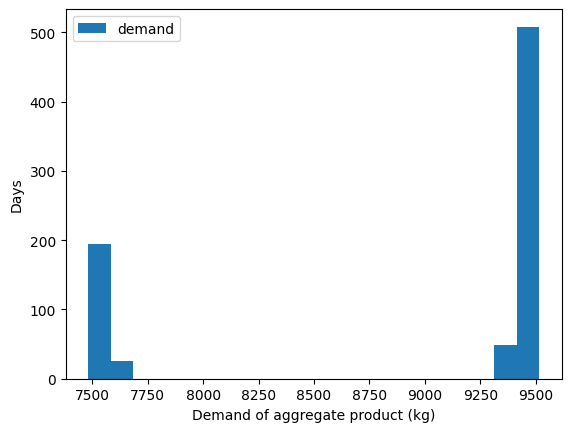

In [7]:
# Draw a histogram of demand

demand = pd.DataFrame(train_data.select('demand').rdd.map(lambda x: x[0]).collect(), columns=['demand'])
demand.plot(kind='hist', bins=20)
plt.xlabel('Demand of aggregate product (kg)')
plt.ylabel('Days')
plt.show()

/Users/yaomaojia/Desktop/Demand_Predict/venv/lib/python3.9/site-packages/pyspark/sql/pandas/conversion.py:251: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


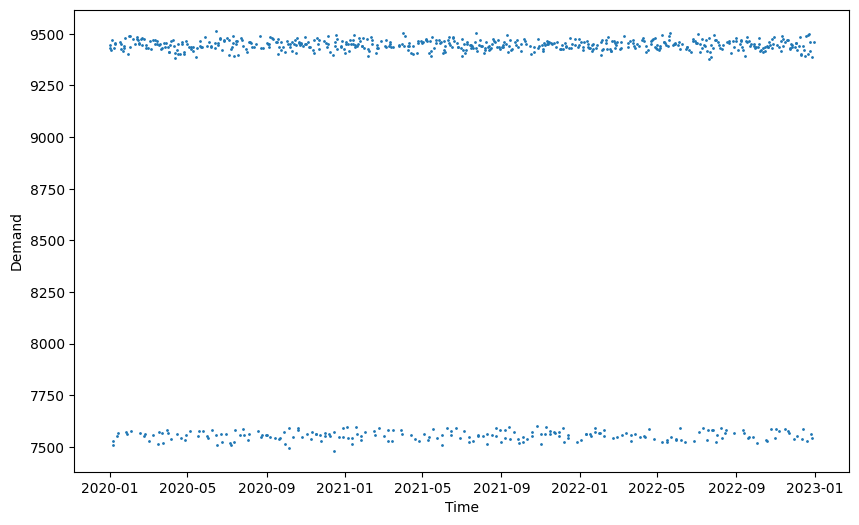

In [8]:
# Draw a scatterplot of demand and time

data = train_data.select('timestamp', 'demand').toPandas()
data['timestamp'] = pd.to_datetime(data['timestamp'])
plt.figure(figsize=(10, 6))
plt.scatter(data['timestamp'], data['demand'], s=1)
plt.xlabel('Time')
plt.ylabel('Demand')
plt.show()

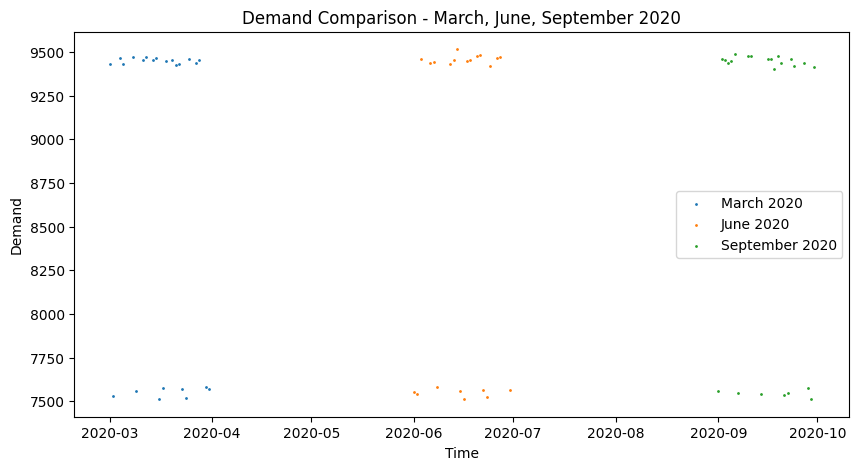

According to the graph, it can be seen that the change in demand changes slightly with the month


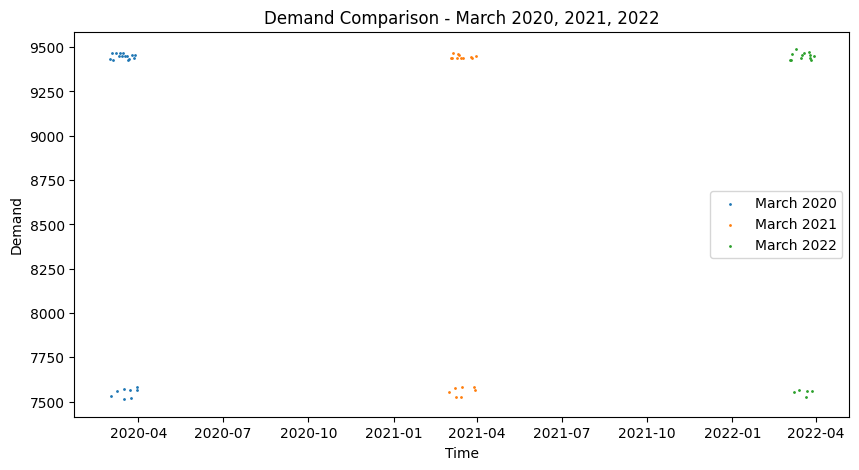

According to the graph, it can be seen that the change in demand changes slightly with the year


In [9]:
# Compare the data of March, June and September of 2020 by the same day
data_2020 = data[data['timestamp'].dt.year == 2020]
data_2020_03 = data_2020[data_2020['timestamp'].dt.month == 3]
data_2020_06 = data_2020[data_2020['timestamp'].dt.month == 6]
data_2020_09 = data_2020[data_2020['timestamp'].dt.month == 9]

# Draw a scatterplot for March, June, and September of 2020
plt.figure(figsize=(10, 5))
plt.scatter(data_2020_03['timestamp'], data_2020_03['demand'], s=1, label='March 2020')
plt.scatter(data_2020_06['timestamp'], data_2020_06['demand'], s=1, label='June 2020')
plt.scatter(data_2020_09['timestamp'], data_2020_09['demand'], s=1, label='September 2020')
plt.xlabel('Time')
plt.ylabel('Demand')
plt.title('Demand Comparison - March, June, September 2020')
plt.legend()
plt.show()

print("According to the graph, it can be seen that the change in demand changes slightly with the month")

# Compare the data for March 2020, March 2021 and March 2022 by the same day
data_mar = data[data['timestamp'].dt.month == 3]
data_2020_03 = data_mar[data_mar['timestamp'].dt.year == 2020]
data_2021_03 = data_mar[data_mar['timestamp'].dt.year == 2021]
data_2022_03 = data_mar[data_mar['timestamp'].dt.year == 2022]

# Draw a scatterplot for March 2020, March 2021 and March 2022
plt.figure(figsize=(10, 5))
plt.scatter(data_2020_03['timestamp'], data_2020_03['demand'], s=1, label='March 2020')
plt.scatter(data_2021_03['timestamp'], data_2021_03['demand'], s=1, label='March 2021')
plt.scatter(data_2022_03['timestamp'], data_2022_03['demand'], s=1, label='March 2022')
plt.xlabel('Time')
plt.ylabel('Demand')
plt.title('Demand Comparison - March 2020, 2021, 2022')
plt.legend()
plt.show()

print("According to the graph, it can be seen that the change in demand changes slightly with the year")

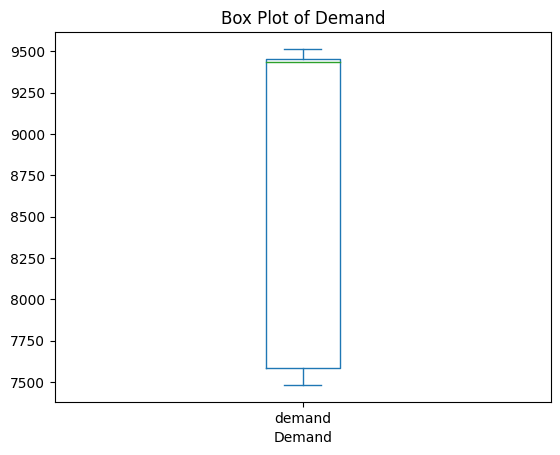

In [10]:
# Use Boxplot to detect outliers and the shape of data distribution

demand = pd.DataFrame(train_data.select('demand').rdd.map(lambda x: x[0]).collect(), columns=['demand'])
demand.plot(kind='box')
plt.title('Box Plot of Demand')
plt.xlabel('Demand')
plt.show()

# Model Training and Prediction

## 1. Linear Regression

In [11]:
# Define Linear Regression Model
lr = LinearRegression(featuresCol="encoded_features", labelCol="demand", regParam=0.01)

# Training model
lr_model = lr.fit(train_data)

# Predict future demand
predictions = lr_model.transform(test_data)

# Calculate the evaluation metrics of the model (MSE, RMSE and R²)
evaluator = RegressionEvaluator(labelCol="demand", predictionCol="prediction")
mse = evaluator.evaluate(predictions, {evaluator.metricName: "mse"})
rmse = evaluator.evaluate(predictions, {evaluator.metricName: "rmse"})
r2 = evaluator.evaluate(predictions, {evaluator.metricName: "r2"})

# Show prediction results
predictions.select("year", "month", "day", "day_of_week", "is_weekend", "demand", "prediction").show()

# Output evaluation results
print("Linear Regression MSE on test data = {:.4f}".format(mse))
print("Linear Regression RMSE on test data = {:.4f}".format(rmse))
print("Linear Regression R² on test data = {:.4f}".format(r2))


23/05/29 13:31:02 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/05/29 13:31:02 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


+----+-----+---+-----------+----------+------+-----------------+
|year|month|day|day_of_week|is_weekend|demand|       prediction|
+----+-----+---+-----------+----------+------+-----------------+
|2020|    1|  4|          7|         1|9454.0|9447.500204666088|
|2020|    1| 11|          7|         1|9420.0|9449.005950733701|
|2020|    1| 12|          1|         1|9447.0|9441.330078524365|
|2020|    1| 15|          4|         0|9465.0| 9444.21483085859|
|2020|    1| 16|          5|         0|9420.0| 9440.58012648482|
|2020|    1| 20|          2|         0|7573.0|7556.641807518638|
|2020|    1| 21|          3|         0|7581.0|7560.854203695164|
|2020|    1| 26|          1|         1|9426.0|9444.345630671613|
|2020|    1| 30|          5|         0|9446.0|9450.270954753849|
|2020|    2|  4|          3|         0|7535.0|7561.623423466756|
|2020|    2|  5|          4|         0|9425.0|9437.676668480093|
|2020|    2|  7|          6|         0|9446.0|9441.879968494393|
|2020|    2|  8|         

## 2. Random Forest Regression

In [12]:
# Create a Random Forest Regression Model
rf = RandomForestRegressor(featuresCol="encoded_features", labelCol="demand", numTrees=1)

# Training model
rf_model = rf.fit(train_data)

# Predict future demand
predictions = rf_model.transform(test_data)

# Calculate the evaluation metrics of the model (MSE, RMSE and R²)
evaluator = RegressionEvaluator(labelCol="demand", predictionCol="prediction")
mse = evaluator.evaluate(predictions, {evaluator.metricName: "mse"})
rmse = evaluator.evaluate(predictions, {evaluator.metricName: "rmse"})
r2 = evaluator.evaluate(predictions, {evaluator.metricName: "r2"})

# Show prediction results
predictions.select("year", "month", "day", "day_of_week", "is_weekend", "demand", "prediction").show()

# Output evaluation results
print("Random Forest MSE on test data = {:.4f}".format(mse))
print("Random Forest RMSE on test data = {:.4f}".format(rmse))
print("Random Forest R² on test data = {:.4f}".format(r2))


+----+-----+---+-----------+----------+------+-----------------+
|year|month|day|day_of_week|is_weekend|demand|       prediction|
+----+-----+---+-----------+----------+------+-----------------+
|2020|    1|  4|          7|         1|9454.0|9448.469387755102|
|2020|    1| 11|          7|         1|9420.0|9448.469387755102|
|2020|    1| 12|          1|         1|9447.0|9448.469387755102|
|2020|    1| 15|          4|         0|9465.0|9442.723214285714|
|2020|    1| 16|          5|         0|9420.0|9445.633663366336|
|2020|    1| 20|          2|         0|7573.0|7559.178571428572|
|2020|    1| 21|          3|         0|7581.0|7560.714285714285|
|2020|    1| 26|          1|         1|9426.0|9448.469387755102|
|2020|    1| 30|          5|         0|9446.0|9445.633663366336|
|2020|    2|  4|          3|         0|7535.0|7560.714285714285|
|2020|    2|  5|          4|         0|9425.0|9442.723214285714|
|2020|    2|  7|          6|         0|9446.0|9447.493827160493|
|2020|    2|  8|         

## 3. Gradient Boosted Tree Regression

In [13]:
# Create a Gradient Boosted Tree Regression Model
gbt = GBTRegressor(featuresCol="encoded_features", labelCol="demand", maxIter=10)

# Training model
gbt_model = gbt.fit(train_data)

# Predict future demand
predictions = gbt_model.transform(test_data)

# Calculate the evaluation metrics of the model (MSE, RMSE and R²)
mse = evaluator.evaluate(predictions, {evaluator.metricName: "mse"})
rmse = evaluator.evaluate(predictions, {evaluator.metricName: "rmse"})
r2 = evaluator.evaluate(predictions, {evaluator.metricName: "r2"})

# Show prediction results
predictions.select("year", "month", "day", "day_of_week", "is_weekend", "demand", "prediction").show()

# Output evaluation results
print("Gradient Boosted Tree MSE on test data = {:.4f}".format(mse))
print("Gradient Boosted Tree RMSE on test data = {:.4f}".format(rmse))
print("Gradient Boosted Tree R² on test data = {:.4f}".format(r2))


+----+-----+---+-----------+----------+------+------------------+
|year|month|day|day_of_week|is_weekend|demand|        prediction|
+----+-----+---+-----------+----------+------+------------------+
|2020|    1|  4|          7|         1|9454.0| 9448.762302621506|
|2020|    1| 11|          7|         1|9420.0| 9414.384126166058|
|2020|    1| 12|          1|         1|9447.0|  9443.56089449112|
|2020|    1| 15|          4|         0|9465.0| 9442.645079487042|
|2020|    1| 16|          5|         0|9420.0|  9443.47630265033|
|2020|    1| 20|          2|         0|7573.0| 7558.083553618195|
|2020|    1| 21|          3|         0|7581.0|7557.7191535611155|
|2020|    1| 26|          1|         1|9426.0| 9448.762302621506|
|2020|    1| 30|          5|         0|9446.0|  9448.22823811737|
|2020|    2|  4|          3|         0|7535.0|7557.7191535611155|
|2020|    2|  5|          4|         0|9425.0| 9440.460307743657|
|2020|    2|  7|          6|         0|9446.0| 9452.356261348204|
|2020|    

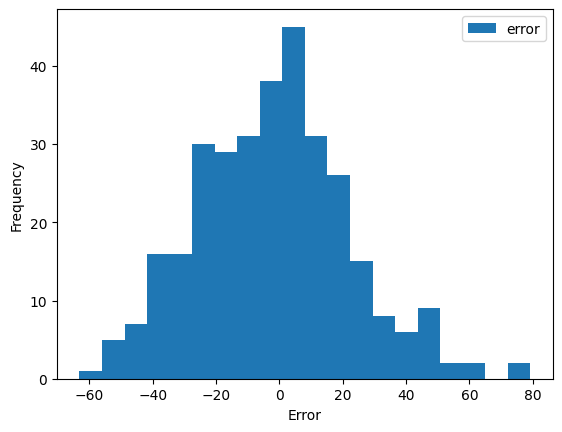

In [14]:
# Select lr_model as an example, and use the prediction error distribution chart to observe whether the prediction error of the model conforms to the normal distribution

# Calculate prediction error
lr_predictions = lr_model.transform(test_data)
lr_errors = lr_predictions.select("demand", "prediction").rdd.map(lambda x: x[0] - x[1]).collect()

# Plotting the distribution of prediction error
pd.DataFrame(lr_errors, columns=['error']).plot(kind='hist', bins=20)
plt.xlabel('Error')
plt.show()

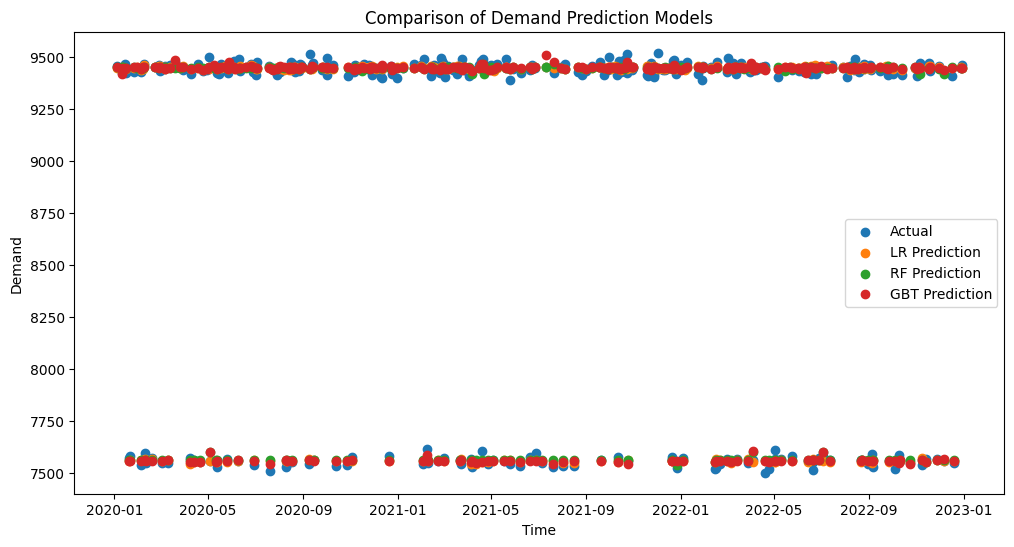

In [15]:
# Prediction using three different models
lr_predictions = lr_model.transform(test_data)
rf_predictions = rf_model.transform(test_data)
gbt_predictions = gbt_model.transform(test_data)

# Create an array of time series
time_series = test_data.select("timestamp").rdd.flatMap(lambda x: x).collect()

# Create a matplotlib chart and plot the actual demand and predictions from each model
fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(time_series, test_data.select("demand").collect(), label="Actual")
ax.scatter(time_series, lr_predictions.select("prediction").collect(), label="LR Prediction")
ax.scatter(time_series, rf_predictions.select("prediction").collect(), label="RF Prediction")
ax.scatter(time_series, gbt_predictions.select("prediction").collect(), label="GBT Prediction")
ax.set_xlabel("Time")
ax.set_ylabel("Demand")
ax.set_title("Comparison of Demand Prediction Models")
ax.legend()

# Show the chart
plt.show()

In [16]:
# Evaluate the predictive performance of each model using MSE, RMSE and R²
lr_evaluator = RegressionEvaluator(labelCol="demand", predictionCol="prediction")
lr_mse = lr_evaluator.evaluate(lr_predictions, {lr_evaluator.metricName: "mse"})
lr_rmse = lr_evaluator.evaluate(lr_predictions, {lr_evaluator.metricName: "rmse"})
lr_r2 = lr_evaluator.evaluate(lr_predictions, {lr_evaluator.metricName: "r2"})

rf_evaluator = RegressionEvaluator(labelCol="demand", predictionCol="prediction")
rf_mse = rf_evaluator.evaluate(rf_predictions, {rf_evaluator.metricName: "mse"})
rf_rmse = rf_evaluator.evaluate(rf_predictions, {rf_evaluator.metricName: "rmse"})
rf_r2 = rf_evaluator.evaluate(rf_predictions, {rf_evaluator.metricName: "r2"})

gbt_evaluator = RegressionEvaluator(labelCol="demand", predictionCol="prediction")
gbt_mse = gbt_evaluator.evaluate(gbt_predictions, {gbt_evaluator.metricName: "mse"})
gbt_rmse = gbt_evaluator.evaluate(gbt_predictions, {gbt_evaluator.metricName: "rmse"})
gbt_r2 = gbt_evaluator.evaluate(gbt_predictions, {gbt_evaluator.metricName: "r2"})

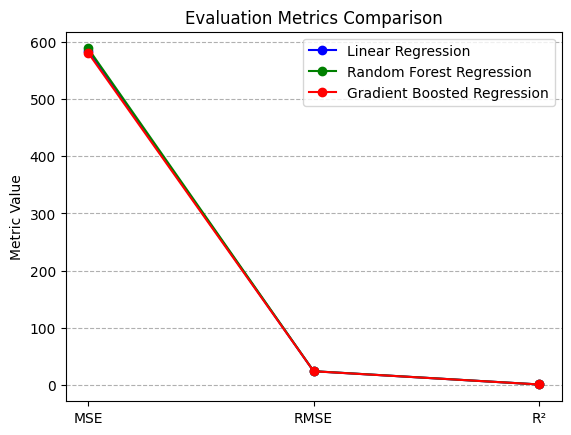

In [17]:
# Define the evaluation metrics for each model
models = ['Linear Regression', 'Random Forest', 'Gradient Boosted Tree']
mse_values = [lr_mse, rf_mse, gbt_mse]
rmse_values = [lr_rmse, rf_rmse, gbt_rmse]
r2_values = [lr_r2, rf_r2, gbt_r2]

# Define the evaluation metrics and corresponding values for linear regression
lr_metrics = ['MSE', 'RMSE', 'R²']
lr_values = [lr_mse, lr_rmse, lr_r2]

# Define the evaluation metrics and corresponding values for random forest regression
rf_metrics = ['MSE', 'RMSE', 'R²']
rf_values = [rf_mse, rf_rmse, rf_r2]

# Define the evaluation metrics and corresponding values for gradient boosting numerical regression
gbt_metrics = ['MSE', 'RMSE', 'R²']
gbt_values = [gbt_mse, gbt_rmse, gbt_r2]

# Set the x-axis values
x = range(len(lr_metrics))

# Plot the line charts
plt.plot(x, lr_values, marker='o', linestyle='-', color='blue', label='Linear Regression')
plt.plot(x, rf_values, marker='o', linestyle='-', color='green', label='Random Forest Regression')
plt.plot(x, gbt_values, marker='o', linestyle='-', color='red', label='Gradient Boosted Regression')

# Add x-axis ticks and labels
plt.xticks(x, lr_metrics)

# Add y-axis label
plt.ylabel('Metric Value')

# Add a grid
plt.grid(axis='y', linestyle='--')

# Set the plot title
plt.title('Evaluation Metrics Comparison')

# Add a legend
plt.legend()

# Show the plot
plt.show()

In [18]:
# Create a dictionary with the evaluation metrics
metrics = {
    'Model': ['Linear Regression', 'Random Forest', 'Gradient Boosted Tree'],
    'MSE': [lr_mse, rf_mse, gbt_mse],
    'RMSE': [lr_rmse, rf_rmse, gbt_rmse],
    'R²': [lr_r2, rf_r2, gbt_r2]
}

# Create a DataFrame from the metrics dictionary
metrics_df = pd.DataFrame(metrics)

# Display the DataFrame
print(metrics_df)

                   Model         MSE       RMSE        R²
0      Linear Regression  584.261240  24.171496  0.999199
1          Random Forest  588.527431  24.259584  0.999193
2  Gradient Boosted Tree  580.802864  24.099852  0.999204


In [20]:
print('After one-hot encoding of all features in feature engineering, the MSE, RMSE and R² evaluation values \
of the three models of linear regression, random forest regression and gradient boosted tree regression have been \
optimized, and the best optimization is linear regression model. The lower the value of MSE and RMSE, the higher \
the value of R² is better. After optimization, the three evaluation indicators of the three models are not much \
different, and the gradient boosted tree regression model with the smallest MSE and RMSE values and the highest R² \
is selected as the final inventory forecasting model')

After one-hot encoding of all features in feature engineering, the MSE, RMSE and R² evaluation values of the three models of linear regression, random forest regression and gradient boosted tree regression have been optimized, and the best optimization is linear regression model. The lower the value of MSE and RMSE, the higher the value of R² is better. After optimization, the three evaluation indicators of the three models are not much different, and the gradient boosted tree regression model with the smallest MSE and RMSE values and the highest R² is selected as the final inventory forecasting model
